In [1]:
import pandas as pd
import requests
import datetime
import numpy as np
from datetime import datetime
import time
from time import sleep
import json
import random

In [2]:
def getPushshiftData(query, after, before, score, sub, endpoint = 'submission', size = 25):
    url = 'https://api.pushshift.io/reddit/search/' + endpoint
    
    parameters = {'subreddit': sub, 'title' : query, 'after' : str(after), 'before' : str(before), 'size': 500, 'score': score}
    
    r = requests.get(url, parameters)
    try:
        data = r.json()
    except:
        data = {'data':[]}
        
    return data['data']

This function will be used later, it is the wrapper around the html request to the pushshift api, which stores reddit data for future querying.  We set parameters, subreddet, query, before and after, size (max 500 pulls at a time) and the minimum score for comments only.

def collectSubData(subm, subStats):
    #subData = list() #list to store data points
    
    pd.DataFrame
    title = subm['title']
    url = subm['url']
    
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
        
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc'])
    numComms = subm['num_comments']
    permalink = subm['permalink']
    text = subm['selftext']
    
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair))
    subStats[sub_id] = subData


def extractStats(data):
    
    subStats = {}
    subCount = 0
    
    while len(data) > 0:
        print(len(data), end = ' , ')
        for submission in data:
            collectSubData(submission, subStats)
            subCount+=1
            
        # Calls getPushshiftData() with the created date of the last submission
        print(len(data), end = " , ")
        print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])), end = ' , ')
        after = data[-1]['created_utc']
        data = getPushshiftData(query, after, before, sub)

    print(len(data))
    return(subStats)

Code snippets from https://rareloot.medium.com/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563.  They are inspiration, we don't actually use them

In [3]:
def dt2unix(before, after, format = "%Y/%m/%d"):
    # input: two strings in the form yyyy/mm/dd
    # returns: tuple (before, after) as unix times
    beforeUnix = time.mktime(datetime.strptime(before, format).timetuple())
    afterUnix = time.mktime(datetime.strptime(after, format).timetuple())
    
    return(int(beforeUnix), int(afterUnix))

This is a helper function, unixtimestamps (the measurements returned by reddit) keeps dates in the format of nanoseconds after 1970, which we cannot use.

In [4]:
def extractData(data):
    dataDF = pd.DataFrame(data)
    toExtract = ['author',
                 'subreddit',
                  'created_utc',
                  'full_link', 
                  'id', 'is_self', 
                  'is_video', 
                  'locked', 
                  'num_comments', 
                  'num_crossposts', 
                  'pinned', 
                  'score',
                 'selftext',
                  'title',
                'body']
    outDF = pd.DataFrame([])
    for query in toExtract:
        try:
            outDF[query] = dataDF[query]
        except:
            pass
        
    return(outDF)

gives a list of items to return, much we don't care about and can actually remove.

In [5]:
def getNews(query, after, before, endpoint, score, sublist = ['news','worldnews','gunpolitics']):
    combinedDF = pd.DataFrame()
    after0 = after
    for sub in sublist:
        print("\n")
        print(sub)
        print(score)
        datai = getPushshiftData(query, after0, before, score, sub, endpoint)
        i = 1
        while(len(datai) > 0):
            print(len(datai), end = ' ')
            dataj = extractData(datai)
            combinedDF = combinedDF.append(dataj)
            after = datai[-1]['created_utc']
            
            print(after, end = ', ')
            
            if i % 10 == 0:
                print("\n")
            i+=1
            
            datai = getPushshiftData(query, after, before, score, sub, endpoint)
            sleep(random.random())
            
    return(combinedDF)

the getNews function is the heart of the scraper, it loops though listed subs and queries, calls the required query functions, and combines all of the extracted data into one dataframe.

In [6]:
class RedditData:
    dataframe = pd.DataFrame()
    datalist = []
    
    
    
    def __init__(self):
        pass
    
    def collect(self, subs, terms, startdate, enddate, endpoint = 'submission', score = '>0'):
        
        # assert that subs, dates, and terms are nonempty
        assert(len(subs) > 0), "Search a Subreddit"
        assert(len(terms) > 0), "Pick a searchterm"
        
        
        after, before = dt2unix(startdate, enddate)
        
        
        if type(terms) == list:
            print(terms)
            for term in terms:
                print(term)
                self.datalist.append(term)
                stories = getNews(term, after, before, endpoint, score, subs)
                stories.insert(0, "Search Term", term)
                self.dataframe = self.dataframe.append(stories)
                
        else:
            print(terms)
            stories = getNews(terms, after, before, endpoint, score, subs)
            stories.insert(0, "Search Term", terms)
            self.dataframe = self.dataframe.append(stories)
            
    def getdata(self):
        return(self.dataframe)

The RedditData class stores the kept data from queries, we keep this as a class since we may make multiple queries and want one place to store all results.

In [7]:
start = '2018/1/1'
stop = '2020/1/1'

Start and stop dates for our search, we want to see the heatwaves in the usa in 2018 and in europe in 2019

In [8]:
stories = RedditData()
stories.collect(['news','worldnews','TrueNews', "InDepthStories"], "heat wave", start,stop, 'submission', '>9')

heat wave


news
>9
28 1570260766, 

worldnews
>9
100 1567955527, 2 1568026993, 

TrueNews
>9


InDepthStories
>9


First we scrape news stories for the phrase 'heat wave'.  When plotted (see below) the frequency of heat waves being mentioned gives a spike around the time of a heatwave and helps us estimate when it is hot/hottest

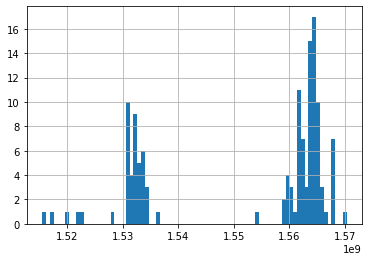

In [9]:
stories.getdata()['created_utc'].hist(bins = 80)

p = stories.getdata()['created_utc'].apply(datetime.fromtimestamp).value_counts()
cutoff = 10
timesvalues = p > cutoff
timesvalues

here we find the times when the counts of data are highest, quick and dirty legacy code and is not part of the final version

In [10]:
counts, rEdge = np.histogram(stories.getdata()['created_utc'], bins = 80)
counts

array([ 1,  0,  1,  0,  0,  0,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0, 10,  4,  9,  5,  6,  3,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  2,  4,  3,  1, 11,
        7,  3, 15, 17, 10,  3,  1,  0,  7,  0,  0,  1])

Using the histogram as defined above we can estimate the heatwave locations by placing them below/above a cutoff value of our chosing.

Legacy code
if counts[0] > cutoff:
    tSeries = 1*(rEdge[0] > times).to_numpy()
else:
    tSeries = 0
    
for i in range(1, len(counts)):
    if counts[i] > cutoff:
        tSeries += ((rEdge[i-1] <= times) & (rEdge[i] > times)).to_numpy()

In [11]:
cutoff = 10
intervals = []
for i in range(len(counts)):
    if counts[i] >= cutoff:
        intervals.append((rEdge[i],rEdge[i+1]))

In [12]:
print(intervals)

[(1530569906.575, 1531254231.7375), (1561364538.8875, 1562048864.05), (1563417514.375, 1564101839.5375), (1564101839.5375, 1564786164.7), (1564786164.7, 1565470489.8625)]


Intervals containing heatwaves defined using a histogram.  We will be able to check easily if a timestamp lies inside one of these intervals to flag it as being a stock/sentiment which was produced during a heatwave or not

In [13]:
def heat(x, intervals):
    for edge in intervals:
        if (x >= edge[0]) & (x <= edge[1]):
            return 1
    return 0

In [14]:
sublist = ['stocks', 'investing','superstonk','stockmarket']
stories.collect(sublist, '*',  start,stop, 'submission', '>49')

*


stocks
>49
100 1518718679, 100 1522617123, 100 1526506923, 100 1530553758, 97 1534681764, 100 1538155363, 100 1553632906, 100 1557489044, 100 1560859798, 100 1564385354, 

100 1567971564, 100 1571843793, 35 1573062921, 

investing
>49
100 1516914510, 100 1518387329, 100 1520076969, 100 1521833655, 100 1523890549, 100 1526054385, 100 1528978961, 100 1531242142, 100 1533219775, 93 1534775267, 

100 1536548589, 100 1550754824, 100 1552576361, 100 1554431424, 100 1556759983, 100 1558703860, 100 1560552426, 100 1562675987, 100 1564539132, 100 1565981749, 

100 1567464850, 100 1569039110, 100 1570825000, 100 1572605373, 39 1574197147, 

superstonk
>49


stockmarket
>49
100 1521686381, 100 1528735994, 97 1534702986, 100 1551237357, 100 1555625357, 100 1559869869, 100 1564337902, 100 1568146285, 100 1573007466, 1 1573064009, 



Here we gather submissions from several subreddits in an attempt to estimate the overall sentiment about the stock.  Comments contain more information but not necessarily about the stock itself, and so they can lead to a less useful model.

In [15]:
len(stories.getdata()['created_utc'].unique())

4691

In [16]:
stockstories = stories.getdata()[stories.getdata()['Search Term'] != "heat wave"]

In [17]:
times = stockstories['created_utc']
tSeries = stockstories['created_utc'].apply(lambda x: heat(x, intervals))

In [18]:
tSeries

0     0
1     0
2     0
3     0
4     0
     ..
96    0
97    0
98    0
99    0
0     0
Name: created_utc, Length: 4562, dtype: int64

In [19]:
pd.DataFrame({'Times': pd.to_datetime(times, unit = 's'), 'Heatwave' : tSeries})

,Times,Heatwave
0,2018-01-02 14:40:06,0
1,2018-01-03 16:13:26,0
2,2018-01-03 22:49:12,0
3,2018-01-04 04:56:18,0
4,2018-01-04 18:41:20,0
...,...,...
96,2019-11-04 21:56:48,0
97,2019-11-05 09:33:48,0
98,2019-11-05 18:40:24,0
99,2019-11-06 02:31:06,0


In [20]:
#df_sentiment = stories.getdata().loc[:,['title','created_utc','Search Term']]
df_sentiment = stockstories.loc[:,['title','body','created_utc', 'subreddit']]
#df_sentiment = stockstories.loc[:,['body','created_utc','subreddit']]
heat_utc = pd.DataFrame({'created_utc': times, 'Heatwave' : tSeries})
df_sentiment = pd.merge(df_sentiment, heat_utc)
df_sentiment['Date'] = pd.to_datetime(df_sentiment['created_utc'], unit = 's').apply(lambda x: x.date())
df_sentiment.index.name = ''
df_sentiment = df_sentiment.drop(columns = 'created_utc')
df_sentiment.index = [e for e in range(len(df_sentiment))]

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Make a dataframe to store the unmodified titles.  They must be cleaned and have sentiment analysis performed on them.

from textblob import TextBlob, Word
from nltk.corpus import stopwords


def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.lower().tags if w not in stopwords.words('english')]
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [23]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/zach/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [25]:
vds = SentimentIntensityAnalyzer()

In [26]:
vds.polarity_scores(df_sentiment['title'].iloc[0])['compound']

0.0

In [27]:
df_sentiment['sentiment'] = df_sentiment['title'].apply(lambda x: vds.polarity_scores(x)['compound'])
df_sentiment.sample(4)

,title,body,subreddit,Heatwave,Date,sentiment
3704,Fundamental Analysis; Alphabet Inc $GOOGL,NaN,StockMarket,0,2018-02-11,0.0000
1852,What is going to happen when Apple repurchases...,NaN,investing,0,2018-05-18,0.2263
1018,Disney missed earnings,NaN,stocks,1,2019-08-07,-0.2960
1148,Costco stock slips with revenue shy of Street ...,NaN,stocks,0,2019-10-03,-0.2500


In [28]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [29]:
import yahoo_fin.stock_info as si

stocksinfo = si.get_data('SPY', start_date = start, end_date = stop)['adjclose']

In [30]:
df_stocksinfo = pd.DataFrame({'Close':stocksinfo, 'Date': stocksinfo.index})
#stocksinfo.index = [e for e in range(len(stocksinfo))]
#df_stocksinfo.index = [e for e in range(len(stocksinfo))]

In [31]:
df_sentiment = df_sentiment.sort_values(by = 'Date')

In [32]:
aggregate_sentiment = []
days = df_sentiment['Date'].unique()
for i,e in enumerate(days):
    #toadd = 0
    #for sub in sublist:
    #    meanadd = df_sentiment[df_sentiment['subreddit']== sub][df_sentiment['Date'] == e]['sentiment'].mean()
    #    if np.isnan(meanadd):
    #        meanadd = 0
            
    #    toadd += meanadd
    
    #toadd = df_sentiment[~df_sentiment['subreddit'].isin(['wallstreetbets'])][df_sentiment['Date'] == e]['sentiment'].sum()
    toadd = df_sentiment[df_sentiment['Date'] == e]['sentiment'].sum()
    
    #if i != 0:
    #    toadd = toadd + aggregate_sentiment[-1]
    
    aggregate_sentiment.append(toadd)

In [33]:
sublist

['stocks', 'investing', 'superstonk', 'stockmarket']

In [34]:
ag_sent_date = pd.DataFrame({'Date': days, 'sentiment':aggregate_sentiment})

In [35]:
ag_sent_date['Date'] = pd.to_datetime(ag_sent_date['Date'])
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])

In [36]:
#df_stocks_sentiment.index = df_stocks_sentiment['Date']
df_stocks_sentiment = pd.merge(df_stocksinfo, ag_sent_date, on = 'Date').sort_values(by = 'Date')


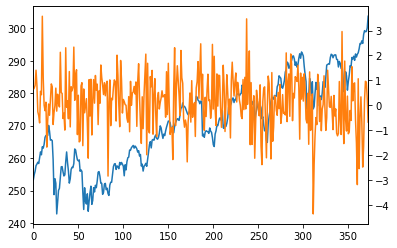

In [37]:
df_stocks_sentiment['Close'].plot()
df_stocks_sentiment['sentiment'].plot(secondary_y = True)

In [38]:
dates = df_stocks_sentiment['Date']
(pd.to_datetime(min(dates), unit = 's').date(),pd.to_datetime(max(dates), unit = 's').date())

(datetime.date(2018, 1, 2), datetime.date(2019, 11, 19))

In [39]:
hwaves = (df_stocks_sentiment['Date'].astype(int)/10**9).apply(lambda x: heat(x, intervals))
hwaves

0      0
1      0
2      0
3      0
4      0
      ..
368    0
369    0
370    0
371    0
372    0
Name: Date, Length: 373, dtype: int64

In [40]:
df_stocks_sentiment['Heat Wave'] = hwaves.to_numpy()

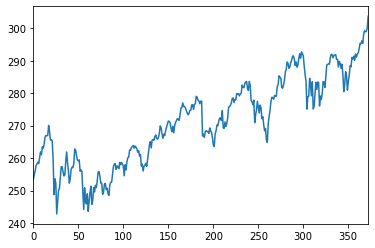

In [41]:
df_stocks_sentiment['Close'].plot()

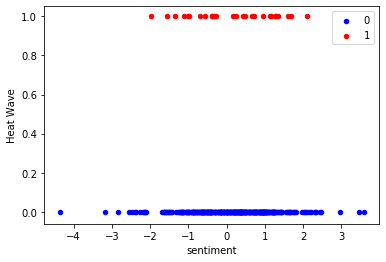

In [42]:

fig, ax = plt.subplots()

colors = {0:'blue',1:'red'}

grouped = df_stocks_sentiment.groupby('Heat Wave')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='sentiment', y = 'Heat Wave', label=key, color=colors[key])

plt.show()

In [43]:
hws = df_stocks_sentiment['Heat Wave']#np.where(df_stocks_reduced['Heat Wave'] == 1)

In [44]:
leading_edges = []
following_edges = []
for i in range(len(hws)):
    if hws[i] == 1:
        if i == 0:
            leading_edges.append(i)
        elif hws[i-1] == 0 :
            leading_edges.append(i)
        
    if hws[i] == 0 :
        if i != 0:
            if hws[i-1] == 1 :
                following_edges.append(i)
                
if len(leading_edges) != len(following_edges):
    if min(leading_edges) > min(following_edges):
        leading_edges = [0] + leading_edges
        
    if max(leading_edge) > max(following_edges):
        following_edges = following_edges + [len(hws)]

In [45]:
#df_stocks_reduced.index = [e for e in range(len(df_stocks_reduced))]
df_stocks_sentiment.index = pd.to_datetime(df_stocks_sentiment['Date'])
print(leading_edges,"\n",following_edges)
df_stocks_sentiment

[126, 276, 293] 
 [131, 282, 309]


,Close,Date,sentiment,Heat Wave
Date,,,,
2018-01-02,253.283142,2018-01-02,0.6369,0
2018-01-03,254.885162,2018-01-03,0.6908,0
2018-01-04,255.959488,2018-01-04,0.8026,0
2018-01-05,257.665283,2018-01-05,1.4078,0
2018-01-08,258.136414,2018-01-08,0.7888,0
...,...,...,...,...
2019-11-04,299.278717,2019-11-04,0.1890,0
2019-11-05,298.947662,2019-11-05,0.9615,0
2019-11-06,299.015808,2019-11-06,0.9263,0


In [46]:
df_stocks_sentiment_2018 = df_stocks_sentiment[df_stocks_sentiment['Date'] < datetime(2019,1,1).date()]
df_stocks_sentiment_2019 = df_stocks_sentiment[df_stocks_sentiment['Date'] >= datetime(2019,1,1).date()]

<ipython-input-46-46b3dcba37bf>:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  df_stocks_sentiment_2018 = df_stocks_sentiment[df_stocks_sentiment['Date'] < datetime(2019,1,1).date()]
<ipython-input-46-46b3dcba37bf>:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  df_stocks_sentiment_2019 = df_stocks_sentiment[df_stocks_sentiment['Date'] >= datetime(2019,1,1).date()]


In [47]:
df_stocks_sentiment_2018 = df_stocks_sentiment_2018.iloc[:-1]

In [48]:
df_stocks_sentiment_2019 = df_stocks_sentiment_2019.iloc[:-1]

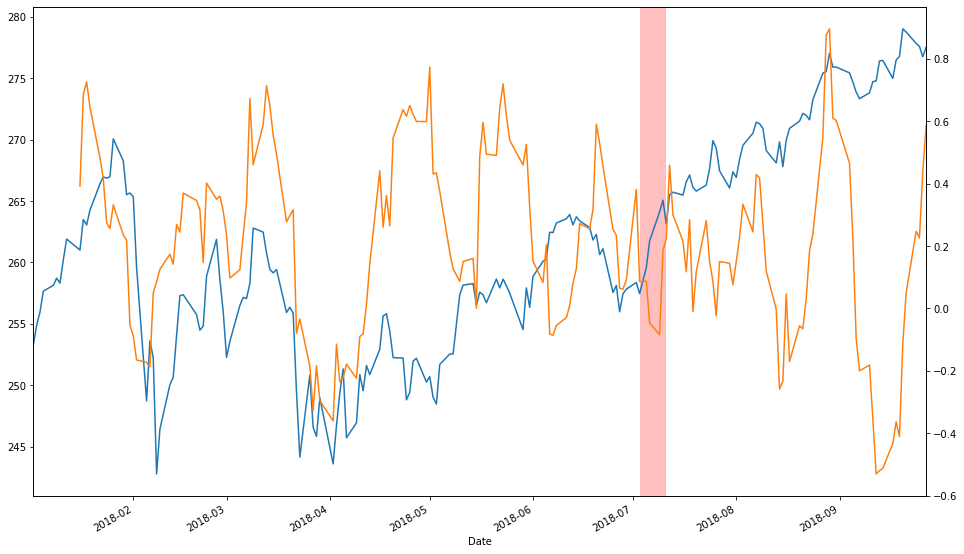

In [49]:
#df_stocks_reduced['Close'].plot()
#df_stocks_reduced['sentiment'].plot(secondary_y = True)

ax = df_stocks_sentiment_2018['Close'].plot(x = 'Date', figsize = (16,10))
for i,j in zip(df_stocks_sentiment['Date'].iloc[leading_edges], df_stocks_sentiment['Date'].iloc[following_edges]):
#for i,j in zip(leading_edges, following_edges):
    ax.axvspan(i,j, facecolor = 'red', alpha= 0.25)
    
df_stocks_sentiment_2018['avg5'] = df_stocks_sentiment_2018['sentiment'].rolling(10).mean()
df_stocks_sentiment_2018['avg5'].plot(x = "Date", secondary_y = True)
#ax2 = df_stocks_reduced.plot(x = 'Date', y = 'sentiment', secondary_y = True)

#plt.show(2

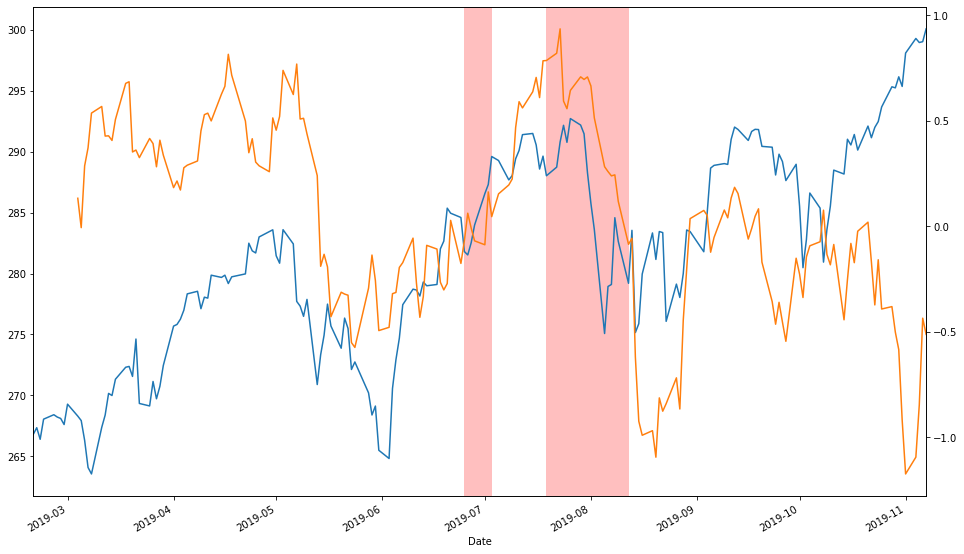

In [50]:
#df_stocks_reduced['Close'].plot()
#df_stocks_reduced['sentiment'].plot(secondary_y = True)

ax = df_stocks_sentiment_2019['Close'].plot(x = 'Date', figsize = (16,10))
for i,j in zip(df_stocks_sentiment['Date'].iloc[leading_edges], df_stocks_sentiment['Date'].iloc[following_edges]):
#for i,j in zip(leading_edges, following_edges):
    ax.axvspan(i,j, facecolor = 'red', alpha= 0.25)
    
df_stocks_sentiment_2019['avg5'] = df_stocks_sentiment_2019['sentiment'].rolling(10).mean()
df_stocks_sentiment_2019['avg5'].plot(x = "Date", secondary_y = True)
#ax2 = df_stocks_reduced.plot(x = 'Date', y = 'sentiment', secondary_y = True)

#plt.show()